# Predicting if a firearm is involved in a crime

#### Using Kansas City Police Department Crime Data 2020

Marissa Berk

## Introduction

Police departments record all crime reports, arrests and details pertaining to these items. This wealth of data can be used to make more accurate predictions; this is referred to as _predictive policing_ or the act of using statistical data to guide police in their decision-making. 

There are many arguments for and against predictive policing. Information from statistical historical data is used to make predictions in order to use law enforcement resources and individuals more efficiently (Ratcliffe, 2004). However, since predictive policing relies on historical data, which is riddled with bias and discrimination; the implementation of predictive policing could result in an increase in bias and discriminatory police interventions. 

My goal is to create a prediction system that can actually decrease confrontation and potential bias in a police confrontation. My accurately predicting whether a firearm is involved in a crime report, police can de-escelate the situation and avoid unneccesarry confrontations, injuries, and/ or deaths.

###### Research Question: 
How can we predict if a firearm is involved in a crime based on historical KCPD data?
###### Sub Question:
Can predictive policing be used to reduce discrimination and confrontation? 

## Data Set

Using the _K-nearest-neighbor_ algorithm, I will predict if a firearm is involved in a crime within the KCPD jurisdiction. 
When responding to 911 calls or crime reports de-escilation is key. If an algorithm can be used to accurately predict whether or not the suspect has a firearm, a more approrpriate police response can be executed. 

The dataset used; _KCPD Crime Data 2020_ can be found here https://data.kcmo.org/Crime/KCPD-Crime-Data-2020/vsgj-uufz 

In [60]:
import seaborn as sns
import sklearn as sk
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #We need this to split the data

import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [61]:
df = pd.read_csv('KCPD_Crime_Data_2020.csv')
df = df.dropna() #first get rid of rows with empty cells 
df.head() #let's take a look at the dataset

,Report_No,Reported_Date,Reported_Time,From_Date,From_Time,To_Date,To_Time,Offense,IBRS,Description,...,Zip Code,Rep_Dist,Area,DVFlag,Involvement,Race,Sex,Age,Firearm_Used,Location
647,KC20013824,2/23/20,22:15,2/18/20,19:46,2/19/20,6:45,Burglary (Residential),220,Burglary/Breaking and Entering,...,64128.0,PJ2325,CPD,N,ARR SUS,B,M,36.0,False,1500 E 29TH ST\nKANSAS CITY 64128\n(39.074446...
706,KC20001720,1/7/20,18:35,1/7/20,18:35,1/7/20,20:36,Stealing – Shoplift,23C,Shoplifting,...,64155.0,PC0323,NPD,N,SUS,W,M,30.0,False,1600 NW 88TH ST\nKANSAS CITY 64155\n(39.25513...
711,KC20002205,1/9/20,15:26,12/27/19,9:00,12/30/19,16:00,Stolen Auto,240,Motor Vehicle Theft,...,64108.0,PJ1938,CPD,N,VIC,B,M,83.0,False,2300 HOLMES ST\nKANSAS CITY 64108\n(39.084761...
944,KC20013925,2/24/20,10:30,2/24/20,1:00,2/24/20,6:00,Stolen Auto,240,Motor Vehicle Theft,...,64127.0,PJ2053,EPD,N,ARR CHA INA SUS VDR,W,M,39.0,False,2400 CYPRESS AVE\nKANSAS CITY 64127\n(39.0820...
977,KC20011846,2/16/20,6:46,2/16/20,6:45,2/16/20,6:46,Stolen Auto,240,Motor Vehicle Theft,...,64102.0,PJ1082,CPD,N,SUS,B,M,25.0,False,1500 W 12TH ST\nKANSAS CITY 64102\n(39.100637...


The variable _Firearm_used_ shows whether or not a firearm was used in the crime reported. This means that `Firearm_Used` will be the dependent variable (Y variable). The independent variables (X variables) used will be determined by how well they correlate with the Y variable.  

# Data Cleaning & Feature Engineering

First, we have to make dummy variables to change the categorical variables into a numerical format so we can see them in the correlation table.

In [62]:
dummies = pd.get_dummies(df['Area'])#make dummie variables for the area
dummies
df = pd.concat([df, dummies], axis=1) #the axis=1 means: add it to the columns


In [63]:
dummies = pd.get_dummies(df['DVFlag']).rename(columns=lambda x: 'DVFlag_' + str(x))#make dummie variables for the domestic violence flag
dummies
df = pd.concat([df, dummies], axis=1) #the axis=1 means: add it to the columns


In [64]:
dummies = pd.get_dummies(df['Sex'])#make dummie variables for the gender
dummies
df = pd.concat([df, dummies], axis=1) #the axis=1 means: add it to the columns


In [65]:
dummies = pd.get_dummies(df['Firearm_Used'])#make dummie variables for the firearm used flag
dummies
df = pd.concat([df, dummies], axis=1) #the axis=1 means: add it to the columns

###### Datetime format
Now we need to use datetime to properly read the date and time variables.

First we convert the date the crime was reported into `datetime` format.
Then we need to use _dayofweek_ from `datetime` to extract the day of the week. This is expressed numerically, with Monday=0, Sunday=6. 

In [66]:
df['Reported_Date'] = pd.to_datetime(df['Reported_Date']) #change to datetime format

df['Weekday_flag'] = (df.Reported_Date.dt.dayofweek < 4) #0-3 indicates Monday, Tuesday, Wednesday, & Thurday



###### Note:
For the purpose of this prediction I will NOT include Friday as a weekday, since Friday and Saturday night tend to be the big 'going out' nights and therefore would affect the crimes occuring. Therefore, Friday will be included as part of the weekend.

Now let's create a dummy variable for the new weekday flag.

In [67]:
dummies = pd.get_dummies(df['Weekday_flag']).rename(columns=lambda x: 'Weekday_flag_' + str(x))#make dummie variables for the domestic violence flag
dummies
df = pd.concat([df, dummies], axis=1) #the axis=1 means: add it to the columns



Now we need to convert the time the crime was reported into `datetime` format. Next, we will create a new variable titled _Day_Flag_ that flags whether a crime occured during the day (True) or at night (False).

In [68]:
df['Reported_Time'] = pd.to_datetime(df['Reported_Time'])
df['Day_flag'] = (df.Reported_Time.dt.hour > 1) & (df.Reported_Time.dt.hour <18)
df.head()

,Report_No,Reported_Date,Reported_Time,From_Date,From_Time,To_Date,To_Time,Offense,IBRS,Description,...,DVFlag_Y,F,M,U,False,True,Weekday_flag,Weekday_flag_False,Weekday_flag_True,Day_flag
647,KC20013824,2020-02-23,2021-01-16 22:15:00,2/18/20,19:46,2/19/20,6:45,Burglary (Residential),220,Burglary/Breaking and Entering,...,0,0,1,0,1,0,False,1,0,False
706,KC20001720,2020-01-07,2021-01-16 18:35:00,1/7/20,18:35,1/7/20,20:36,Stealing – Shoplift,23C,Shoplifting,...,0,0,1,0,1,0,True,0,1,False
711,KC20002205,2020-01-09,2021-01-16 15:26:00,12/27/19,9:00,12/30/19,16:00,Stolen Auto,240,Motor Vehicle Theft,...,0,0,1,0,1,0,True,0,1,True
944,KC20013925,2020-02-24,2021-01-16 10:30:00,2/24/20,1:00,2/24/20,6:00,Stolen Auto,240,Motor Vehicle Theft,...,0,0,1,0,1,0,True,0,1,True
977,KC20011846,2020-02-16,2021-01-16 06:46:00,2/16/20,6:45,2/16/20,6:46,Stolen Auto,240,Motor Vehicle Theft,...,0,0,1,0,1,0,False,1,0,True


Now we must create a dummy variable for the new column.

In [69]:
dummies = pd.get_dummies(df['Day_flag']).rename(columns=lambda x: 'Day_flag_' + str(x))#make dummie variables for the day time flag
dummies
df = pd.concat([df, dummies], axis=1) #the axis=1 means: add it to the columns


###### Note
This variable was added after the initial prediction was completed. The best results were found using KNN
    -


# Variable Selection

Now let's take a look at how the variables correlate to eachother so we can select which variables to use in our prediction model.

In [70]:
df.corr()

,Zip Code,Age,Firearm_Used,CPD,EPD,MPD,NPD,OSPD,SCP,SPD,...,M,U,False,True,Weekday_flag,Weekday_flag_False,Weekday_flag_True,Day_flag,Day_flag_False,Day_flag_True
Zip Code,1.000000,0.008747,0.006793,0.014658,0.018175,-0.070073,0.013515,0.000366,0.014106,0.013117,...,0.021846,0.001644,-0.006793,0.006793,0.039870,-0.039870,0.039870,0.039970,-0.039970,0.039970
Age,0.008747,1.000000,-0.064485,-0.127514,0.021030,0.050317,0.031015,-0.005328,0.040125,0.017648,...,0.060232,-0.051906,0.064485,-0.064485,0.016024,-0.016024,0.016024,0.076394,-0.076394,0.076394
Firearm_Used,0.006793,-0.064485,1.000000,-0.093895,0.111143,0.057085,-0.020499,-0.003254,-0.032246,-0.032760,...,0.025318,0.013114,-1.000000,1.000000,-0.035030,0.035030,-0.035030,-0.121262,0.121262,-0.121262
CPD,0.014658,-0.127514,-0.093895,1.000000,-0.321339,-0.276760,-0.187968,-0.009649,-0.228885,-0.212490,...,0.029382,0.030744,0.093895,-0.093895,-0.042507,0.042507,-0.042507,-0.028471,0.028471,-0.028471
EPD,0.018175,0.021030,0.111143,-0.321339,1.000000,-0.252294,-0.171352,-0.008796,-0.208652,-0.193706,...,0.021872,0.003156,-0.111143,0.111143,0.035657,-0.035657,0.035657,-0.005621,0.005621,-0.005621
MPD,-0.070073,0.050317,0.057085,-0.276760,-0.252294,1.000000,-0.147580,-0.007576,-0.179706,-0.166833,...,-0.037837,-0.026282,-0.057085,0.057085,0.002523,-0.002523,0.002523,0.023218,-0.023218,0.023218
NPD,0.013515,0.031015,-0.020499,-0.187968,-0.171352,-0.147580,1.000000,-0.005145,-0.122051,-0.113309,...,0.032359,-0.017850,0.020499,-0.020499,0.028466,-0.028466,0.028466,-0.020218,0.020218,-0.020218
OSPD,0.000366,-0.005328,-0.003254,-0.009649,-0.008796,-0.007576,-0.005145,1.000000,-0.006265,-0.005817,...,0.013788,-0.000916,0.003254,-0.003254,-0.019881,0.019881,-0.019881,0.008909,-0.008909,0.008909
SCP,0.014106,0.040125,-0.032246,-0.228885,-0.208652,-0.179706,-0.122051,-0.006265,1.000000,-0.137974,...,-0.011031,0.006262,0.032246,-0.032246,0.003668,-0.003668,0.003668,-0.010796,0.010796,-0.010796
SPD,0.013117,0.017648,-0.032760,-0.212490,-0.193706,-0.166833,-0.113309,-0.005817,-0.137974,1.000000,...,-0.042229,-0.005369,0.032760,-0.032760,-0.019958,0.019958,-0.019958,0.048088,-0.048088,0.048088


Now we need to decide which variables to include. Any variable that correlates with `Firearm_Used` by more than 0.05 will be included.

This means the following variables will be included:
    - Sex
    - Age
    - Area
    - Day_flag

The correlation of the above variables are illustrated in a heatmap below. 

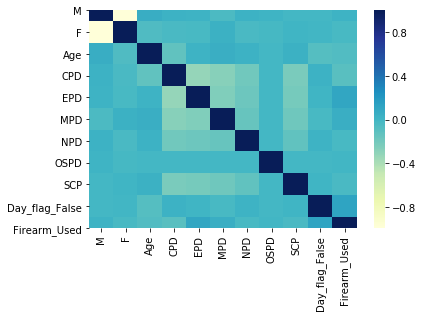

In [71]:
corr = df[['M', 'F', 'Age', 'CPD', 'EPD', 'MPD', 'NPD', 'OSPD', 'SCP', 'Day_flag_False', 'Firearm_Used']].corr() 
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="YlGnBu") #the last two arguments set the column names
plt.show()

# Random Forest Algorithm

The _Random Forest Algorithm_ is an extension of the decision tree algorithm, it improves accuracy at the cost of interpritability. The decision tree algorithm uses training data (historical data) to predict the class or branch. 

In [72]:
from sklearn.preprocessing import normalize #get the function needed to normalize our data.

X = df[['M', 'F', 'Age', 'CPD', 'EPD', 'MPD', 'NPD', 'OSPD', 'SCP', 'Day_flag_False']] #create the X matrix
X = normalize(X) #normalize the matrix to put everything on the same scale
y = df['Firearm_Used'] #create the y-variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #split the data, store it into different variables

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier() #create a Random forest-classifier 
rf = rf.fit(X_train, y_train) #this fits the k-nearest neigbor model with the train data
rf.score(X_test, y_test) #calculate the fit on the test data

/Users/marissa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9454705364995603

94% of firearm uses are predicted accurately, this is very good. But let's look at the confusion matrix to see how well the model identifies the different scenarios. A confusion matrix gives the different classes and the number of predictions for each combination.

In [16]:
from sklearn.metrics import confusion_matrix
y_test_pred = rf.predict(X_test) #the predicted values
cm = confusion_matrix(y_test, y_test_pred) #creates a "confusion matrix"
cm

array([[1073,    8],
       [  54,    2]])

In [17]:
conf_matrix = pd.DataFrame(cm, index=['Firearm NOT present (actual)', 'Firearm present (actual)'], columns = ['Firearm NOT present (predicted)', 'Firearm present (predicted)']) 
conf_matrix

,Firearm NOT present (predicted),Firearm present (predicted)
Firearm NOT present (actual),1073,8
Firearm present (actual),54,2


The way to read this is that of the cases where a firearm is present, 2 cases are correctly predicted as 'firearm present', 8 crimes that were predicted as having firearms present actually did NOT have a firearm. And of those who were predicted to NOT have any firearms present, 1073 were predicted correctly, while 54 actually did have a firearm present. The _recall_ and _precision_ for the firearm present predictions:

$recall = \frac{2}{54 + 2} = .03$

$precision = \frac{2 }{ 8 + 2} = .2$


The _Recall_ is 3%

The _Precision_ is 20%

If the goal was to make sure officers are prepared for all violent situations than the`Random Forest Algorithm` would be the best option. But since the goal is to reduce confrontation, the `K Nearest Neighbor Algorithm` is better (see results below). The `Random Forest Algorithm` predicts 8 cases of a firearm being present even though a firearm wasn't actually present, this is 8 instances where a suspect is unneccesarily shot at even though he or she was unarmed, as opposed to 2 cases (when using the KNN Algorithm with n_neighbors=5). 

# K-nearest Neighbor Algorithm

The _K-nearest neighbor_ algorithm determines the value of a data point by using the data points that are _close_ to it. kNN classifier determines the class of a data point by majority voting principle. If k is set to 5, the classes of 5 closest points are checked. Prediction is done according to the majority class. Similarly, kNN regression takes the mean value of 5 closest points.

### n_neighbors = 1

In [73]:
from sklearn.neighbors import KNeighborsClassifier #the object class we need

knn = KNeighborsClassifier(n_neighbors=1) #create a KNN-classifier with 5 neighbors (default)
knn = knn.fit(X_train, y_train) #this fits the k-nearest neigbor model with the train data
knn.score(X_test, y_test) #calculate the fit on the test data

0.9138082673702727

The accuracy is 91%, this is lower than before when n_neighbors = 5 (accuracy of 95%). But let's look at the confusion matrix to determine precision and recall.

In [74]:
from sklearn.metrics import confusion_matrix
y_test_pred = knn.predict(X_test) #the predicted values
cm = confusion_matrix(y_test, y_test_pred) #creates a "confusion matrix"
cm

array([[1035,   46],
       [  52,    4]])

In [75]:
conf_matrix = pd.DataFrame(cm, index=['Firearm NOT present (actual)', 'Firearm present (actual)'], columns = ['Firearm NOT present (predicted)', 'Firearm present (predicted)']) 
conf_matrix

,Firearm NOT present (predicted),Firearm present (predicted)
Firearm NOT present (actual),1035,46
Firearm present (actual),52,4


The way to read this is that of the cases where a firearm is present, 4 case are correctly predicted as 'firearm present', 52 crimes that were predicted as having no firearms present actually did have a firearm. And of those who were predicted to NOT have any firearms present, 1035 were predicted correctly, while 52 actually did have a firearm present. The _recall_ and _recision_ for the firearm present predictions:

$recall = \frac{4}{52 + 4} = .07$

$precision = \frac{4 }{ 46 + 4} = .08$


The _Recall_ is 7%

The _Precision_ is 8%

In this scenario, the prediction was less accurate. But more importantly, the precision is lower. Since the goal is to reduce confrontation; having 46 cases where the officer is told the suspect has a firearm when in fact they do not, is not good. That's 46 opportunities where an officer could accidentally kill or injure an unarmed person because the prediction model told them to expect the suspect to have a firearm. 

We might improve our scores by trying out different values of _k_.

### n_neighbors = 50

In [76]:
from sklearn.neighbors import KNeighborsClassifier #the object class we need

knn = KNeighborsClassifier(n_neighbors=50) #create a KNN-classifier with 5 neighbors (default)
knn = knn.fit(X_train, y_train) #this fits the k-nearest neigbor model with the train data
knn.score(X_test, y_test) #calculate the fit on the test data

0.9507475813544415

The accuracy is 95%, although this may seem like the best option, what would happen if we predict that a firearm is not present 100% of the time?

In [77]:
from sklearn.metrics import confusion_matrix
y_test_pred = knn.predict(X_test) #the predicted values
cm = confusion_matrix(y_test, y_test_pred) #creates a "confusion matrix"
cm

array([[1081,    0],
       [  56,    0]])

In [78]:
conf_matrix = pd.DataFrame(cm, index=['Firearm NOT present (actual)', 'Firearm present (actual)'], columns = ['Firearm NOT present (predicted)', 'Firearm present (predicted)']) 
conf_matrix

,Firearm NOT present (predicted),Firearm present (predicted)
Firearm NOT present (actual),1081,0
Firearm present (actual),56,0


The way to read this is that of the cases where a firearm is present, 0 case are correctly predicted as 'firearm present', 56 crimes that were predicted as having no firearms present actually did have a firearm. And of those who were predicted to NOT have any firearms present, 1035 were predicted correctly, while 56 actually did have a firearm present. The _recall_ and _recision_ for the firearm present predictions:

$recall = \frac{0}{56 + 0} = .00$

$precision = \frac{0 }{ 0 + 0} = .00$


The _Recall_ is 0%

The _Precision_ is 0%

In this scenario, the overall prediction was more accurate than when n_neighbors= 1; however, it appears that the algorithm just predicts that a firearm is not present 100% of the time. This is why the recall and accuracy is so low. Even if we have a 95% accuracy, it is not a good prediction method to simply assume that no suspects are carrying firearms, this could potentially result in officer injury.

We might improve our scores by trying out different values of _k_.

### n_neighbors = 5

In [79]:
from sklearn.neighbors import KNeighborsClassifier #the object class we need

knn = KNeighborsClassifier(n_neighbors=5) #create a KNN-classifier with 5 neighbors (default)
knn = knn.fit(X_train, y_train) #this fits the k-nearest neigbor model with the train data
knn.score(X_test, y_test) #calculate the fit on the test data

0.9498680738786279

95% of firearm uses are predicted accurately, this is very good. But let's look at the confusion matrix to see how well the model identifies the different scenarios. A confusion matrix gives the different classes and the number of predictions for each combination.

In [80]:
from sklearn.metrics import confusion_matrix
y_test_pred = knn.predict(X_test) #the predicted values
cm = confusion_matrix(y_test, y_test_pred) #creates a "confusion matrix"
cm

array([[1079,    2],
       [  55,    1]])

In [81]:
conf_matrix = pd.DataFrame(cm, index=['Firearm NOT present (actual)', 'Firearm present (actual)'], columns = ['Firearm NOT present (predicted)', 'Firearm present (predicted)']) 
conf_matrix

,Firearm NOT present (predicted),Firearm present (predicted)
Firearm NOT present (actual),1079,2
Firearm present (actual),55,1


The way to read this is that of the cases where a firearm is present, 1 case is correctly predicted as 'firearm present', 55 crimes that were predicted as having no firearms present actually did. And of those who were predicted to NOT have any firearms present, 1079 were predicted correctly, while 55 actually did have a firearm present. The _recall_ and _precision_ for the firearm present predictions:

$recall = \frac{1}{55 + 1} = .017$

$precision = \frac{1 }{ 2 + 1} = .33$


The _Recall_ is 17%

The _Precision_ is 33%

We might improve our scores by trying out different values of _k_, or including more variables.

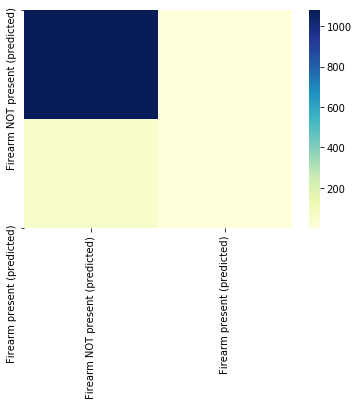

In [82]:
sns.heatmap(conf_matrix, xticklabels=conf_matrix.columns, yticklabels=conf_matrix.columns, cmap="YlGnBu") #the last two arguments set the column names
plt.show()

As depicted by the heatmap, the prediction works much better when a firearm is NOT present than when one is. Although ideally, we want our predictions to be 100% accurate accross the board, this is often difficult (if not impossible to achieve). Since the goal of this prediction system is to reduce confrontation the precision is more important than the accuracy. 

# Results

After multiple trials, it was determined that the `K Nearest Neighbor Algorithm` with n_neighbors = 5 is the most accurate prediction. 

The _Accuracy_ = 95%

The _Recall_ is 17%

The _Precision_ is 33%

# Improving the prediction model

Although the accuracy is quite high, the precision and recall are not great considering there are 55 instances where no firearm was predicted but the suspect did have a firearm. Let's see if we can try to improve this by including some additional variables.

In [83]:
dummies = pd.get_dummies(df['Offense'])#make dummie variables for the area
dummies
df = pd.concat([df, dummies], axis=1) #the axis=1 means: add it to the columns



In [84]:
dummies = pd.get_dummies(df['Description'])#make dummie variables for the area
dummies
df = pd.concat([df, dummies], axis=1) #the axis=1 means: add it to the columns


In [85]:
from sklearn.preprocessing import normalize #get the function needed to normalize our data.

x = df[['M', 'F', 'Age', 'CPD', 'EPD', 'MPD', 'NPD', 'OSPD', 'SCP', 'Day_flag_False','Stolen Auto', 'Trafficking in Identifications', 'Stealing – Shoplift', 'Alcohol Influence Report', 'Assault (Aggravated)','City Weapons Offense', 'Disorderly Conduct','Weapon Law Violations','Aggravated Assault']] #create the X matrix
x = normalize(x) #normalize the matrix to put everything on the same scale
y = df['Firearm_Used'] #create the y-variable
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) #split the data, store it into different variables

In [86]:
from sklearn.neighbors import KNeighborsClassifier #the object class we need

knn = KNeighborsClassifier(n_neighbors=5) #create a KNN-classifier with 5 neighbors (default)
knn = knn.fit(x_train, y_train) #this fits the k-nearest neigbor model with the train data
knn.score(x_test, y_test) #calculate the fit on the test data

0.980650835532102

98% of firearm uses are predicted accurately, this is very good. But let's look at the confusion matrix to see how well the model identifies the different scenarios. A confusion matrix gives the different classes and the number of predictions for each combination.

In [87]:
from sklearn.metrics import confusion_matrix
y_test_pred = knn.predict(x_test) #the predicted values
cm = confusion_matrix(y_test, y_test_pred) #creates a "confusion matrix"
cm

array([[1078,    3],
       [  19,   37]])

In [88]:
conf_matrix2 = pd.DataFrame(cm, index=['Firearm NOT present (actual)', 'Firearm present (actual)'], columns = ['Firearm NOT present (predicted)', 'Firearm present (predicted)']) 
conf_matrix2


,Firearm NOT present (predicted),Firearm present (predicted)
Firearm NOT present (actual),1078,3
Firearm present (actual),19,37


The way to read this is that of the cases where a firearm is present, 38 cases are correctly predicted as 'firearm present', 18 crimes that were predicted as having no firearms present actually did. And of those who were predicted to NOT have any firearms present, 1078 were predicted correctly, while 18 actually did have a firearm present. The _recall_ and _precision_ for the firearm present predictions:

$recall = \frac{38}{18 + 38} = .67$

$precision = \frac{38 }{ 3 + 38} = .92$


The _Recall_ is 67%

The _Precision_ is 92%

These are by far the best results we have gotten. Even though we do have a slight increase (from 2 to 3) for the instance where there is NO firearm present but the prediction states there is; the model has become much more effective at predicting the firearm present instances. 

##### References

Ratcliffe, J. H. (2004). The hotspot matrix: A framework for the spatio‐temporal targeting of crime reduction. Police Practice and Research, 5(1), 5–23. 